In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from plotting_constants import nice_names, color_dict, stack_to_ax

idx = pd.IndexSlice

In [3]:
results = pd.read_csv(
    Path.cwd().parent /
    'summaries' /
    'total_summary_flex.csv',
    index_col=[0,1],
    parse_dates=True
    )

model_balancing_volume = results.loc[results.index.get_level_values(1) == 'balancing_volume']
results = results.loc[~(results.index.get_level_values(1) == 'balancing_volume')]

C:\Users\lukas\AppData\Local\Temp\ipykernel_5140\199033386.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  results = pd.read_csv(


In [4]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'bmus_prepared.csv', index_col=0)

In [5]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

all_bids = []

for day in tqdm(sorted(model_balancing_volume.index.get_level_values(0).strftime('%Y-%m-%d').unique())):

    try:
        bids = pd.read_csv(Path.cwd().parent / 'data' / 'base' / f'{day}' / 'bids.csv', index_col=[0,1], parse_dates=True)
    except FileNotFoundError:
        continue

    all_bids.append(bids)

all_bids = pd.concat(all_bids)

100%|██████████| 1083/1083 [00:05<00:00, 204.43it/s]


In [6]:
idx = pd.IndexSlice

real_bid_vol = all_bids.loc[
    idx[:,'vol'],
    # idx['2022-11','vol'],
    all_bids.columns.intersection(
        bmus
        .index[bmus.carrier.isin(['onwind', 'offwind', 'cascade', 'ror', 'PHS', 'fossil'])]
        )
    # :
].sum(axis=1)


real_bid_vol.index = real_bid_vol.index.droplevel(1)
# real_bid_vol = real_bid_vol.groupby(real_bid_vol.index.strftime('%Y-%m')).sum().mul(1e-3)
real_bid_vol = real_bid_vol.groupby(real_bid_vol.index.strftime('%Y-%m')).sum().mul(1e-3)

In [7]:
mmb = (
    # model_balancing_volume.loc['2022-11', 'national']
    model_balancing_volume.loc[:, 'national']
    .groupby(
        model_balancing_volume# .loc['2022-11']
        .index
        .get_level_values(0)
        .strftime('%Y-%m')
        # .strftime('%Y-%m-%d')
    ).sum()
    .mul(1e3)
)

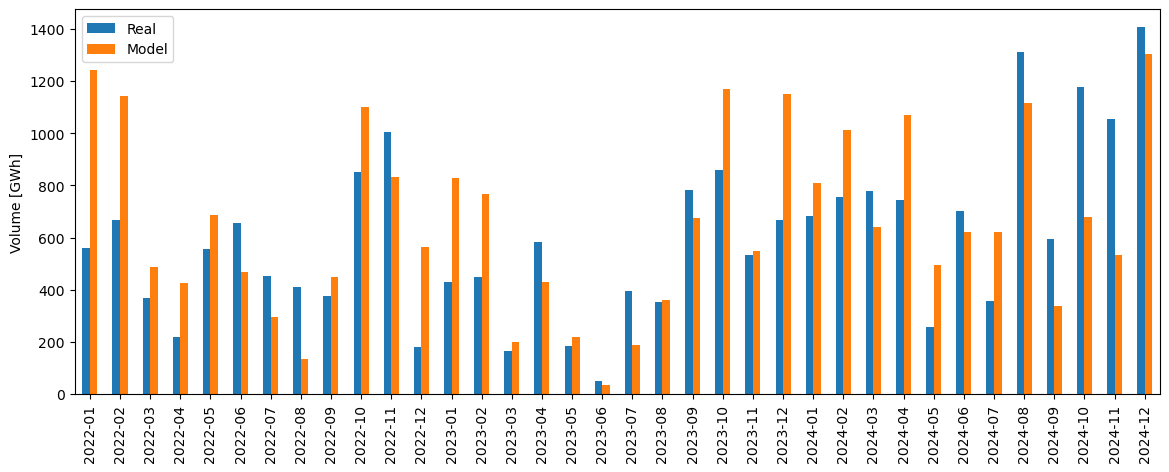

In [11]:
fig, ax = plt.subplots(figsize=(14, 5))

# real_bid_vol.plot.bar(ax=ax)
# mmb.plot.bar(ax=ax, color='red')

plotdata = pd.concat([real_bid_vol, mmb], axis=1)
plotdata.columns = ['Real', 'Model']

plotdata.plot.bar(ax=ax)
ax.set_ylabel('Volume [GWh]')

plt.savefig('balancing_volume_validation.pdf', bbox_inches='tight')
plt.show()

In [9]:
# print('real congestion management bids: ', int(real_bid_vol.drop(index=['2022-11-20', '2022-11-22']).sum().sum()), 'GWh')
# print('model congestion management bids: ', int(mmb.drop(index=['2022-11-20', '2022-11-22']).sum()), 'GWh')
print('real congestion management bids: ', int(real_bid_vol.sum().sum()), 'GWh')
print('model congestion management bids: ', int(mmb.sum()), 'GWh')

real congestion management bids:  21586 GWh
model congestion management bids:  23645 GWh


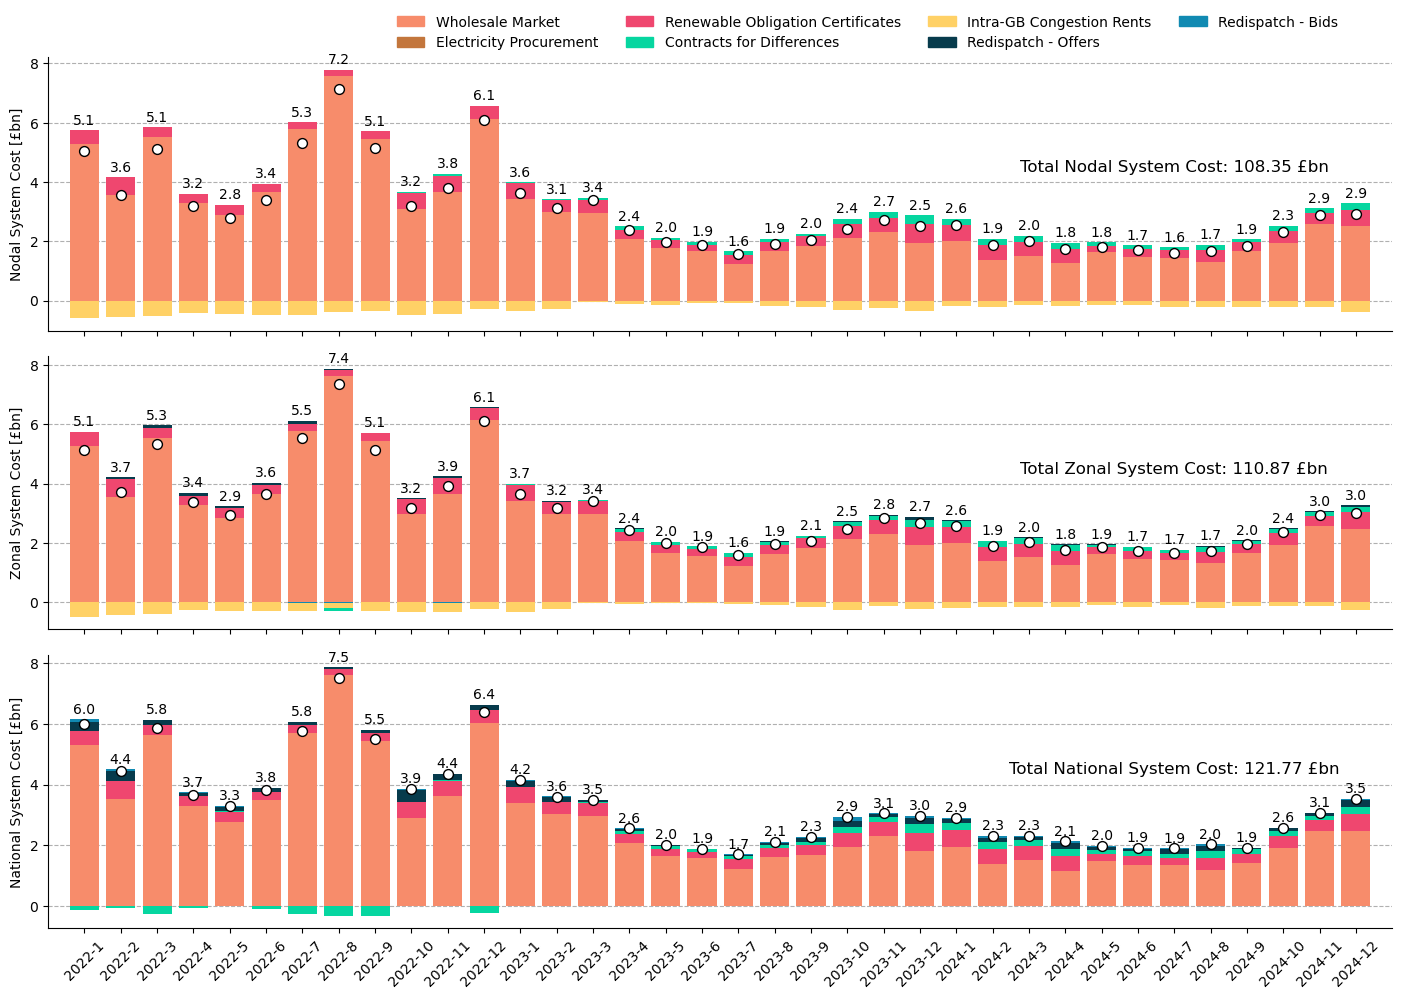

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for col, ax in zip(results.columns, axs):

    ts = results.index.get_level_values(0).unique()

    df_unstack = results.loc[idx[:, :], col].unstack()
    df = df_unstack.groupby([df_unstack.index.year, df_unstack.index.month]).sum().mul(1e-3)

    for m in df.index:
        # stack_to_ax(total_costs, df.loc[[m]], ax)
        stack_to_ax(df.loc[[m]], ax)

    ax.set_ylabel(f'{col.capitalize()} System Cost [£bn]')
    ax.grid(axis='y', linestyle='--')
    ax.set_axisbelow(True)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlim(-1, len(df))

    total_cost = df.sum().sum()
    ax.text(
        len(df) - 6, 4.5,
        f'Total {col.capitalize()} System Cost: {np.around(total_cost, decimals=2)} £bn',
        ha='center',
        va='center',
        fontsize=12,
        # transform=ax.transAxes
    )

axs[2].tick_params(axis='x', labelrotation=45)

handles, labels = [], []

for name, nice_name in nice_names.items():
    handles.append(plt.Rectangle((0, 0), 1, 1, color=color_dict[name]))
    labels.append(nice_name)

axs[0].legend(
    handles,
    labels,
    # title='Cost Factors',
    # bbox_to_anchor=(1.01, 1.2),
    bbox_to_anchor=(0.25, 1.2),
    frameon=False,
    ncol=4
    )

plt.tight_layout()

plt.savefig('total_monthly_costs.pdf')
plt.show()

In [98]:
nquants = len(results.index.get_level_values(1).unique())

total_date_range = pd.date_range(
    results.index.get_level_values(0).min().strftime('%Y-%m'),
    results.index.get_level_values(0).max().strftime('%Y-%m'),
    freq='ME').strftime('%Y-%m')

total_hh = pd.date_range(
    results.index.get_level_values(0).min().strftime('%Y-%m-%d'),
    results.index.get_level_values(0).max().strftime('%Y-%m-%d'),
    freq='30min')

missing_share = pd.Series(np.nan, total_date_range)

for m in total_date_range:

    n_modelled = len(results.loc[idx[m, :], :]) / nquants
    n_total = pd.date_range(m, pd.Timestamp(m) + pd.offsets.MonthEnd(1), freq='30min')

    missing_share[m] = 1 - n_modelled / len(n_total)